# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import signatory
import numpy as np
import pandas as pd
import datetime
from IPython.display import display

import base
import market_generator
from utils import tosig

In [2]:
import math
import torch
import signatory

# Create a path consisting in a half circle
time = torch.linspace(0, 1, 10)
path = torch.stack([torch.cos(math.pi * time), torch.sin(math.pi * time)]).T.unsqueeze(0)
print("path shape: {}".format(path.shape))

# Compute the signature
depth = 11
signature = signatory.signature(path, depth)
print("signature shape: {}".format(signature.shape))

# Reconstruct the path by inverting the signature
reconstructed_path = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])

path shape: torch.Size([1, 10, 2])
signature shape: torch.Size([1, 4094])


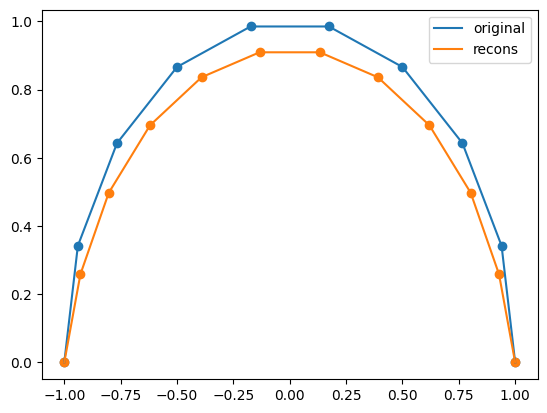

In [3]:
import matplotlib.pyplot as plt

reconstructed_path = reconstructed_path.squeeze()
path = path.squeeze()

plt.plot(path[:,0],path[:,1])
plt.scatter(path[:,0],path[:,1])
plt.plot(reconstructed_path[:,0],reconstructed_path[:,1])
plt.scatter(reconstructed_path[:,0],reconstructed_path[:,1])
plt.legend(["original","recons"])

In [4]:
# Signature order
order = 4

## Load monthly paths

In [6]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="M", sig_order=order)

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['^GSPC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-01 -> 2019-01-01)')



Download data successfully
Shape of downloaded data:(0, 6)
Apply lead lag transformation...


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

## Plot paths

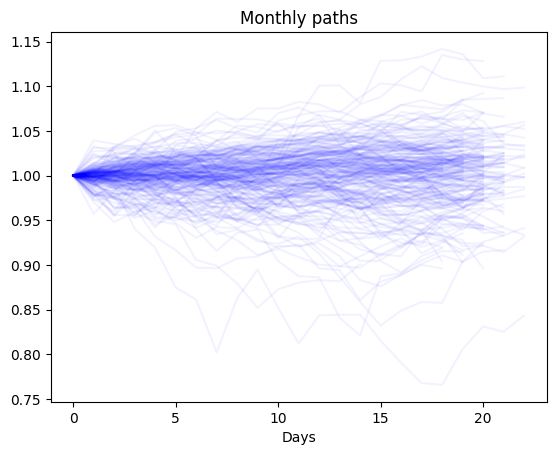

In [ ]:
for path in MG.windows:
    temp_path = path.squeeze()
    returns = temp_path[::2, 1] / temp_path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [ ]:
MG.train(n_epochs=500)

Data shape:torch.Size([219, 22620])
Data condition shape:torch.Size([219, 22620])
Epoch 0: 43130.765625
Epoch 1: 1287531.875
Epoch 2: nan
Epoch 3: nan
Epoch 4: nan
Epoch 5: nan
Epoch 6: nan
Epoch 7: nan
Epoch 8: nan
Epoch 9: nan
Epoch 10: nan
Epoch 11: nan
Epoch 12: nan
Epoch 13: nan
Epoch 14: nan
Epoch 15: nan
Epoch 16: nan
Epoch 17: nan
Epoch 18: nan
Epoch 19: nan
Epoch 20: nan
Epoch 21: nan
Epoch 22: nan
Epoch 23: nan
Epoch 24: nan
Epoch 25: nan
Epoch 26: nan
Epoch 27: nan
Epoch 28: nan
Epoch 29: nan
Epoch 30: nan
Epoch 31: nan
Epoch 32: nan
Epoch 33: nan
Epoch 34: nan
Epoch 35: nan
Epoch 36: nan
Epoch 37: nan
Epoch 38: nan
Epoch 39: nan
Epoch 40: nan
Epoch 41: nan
Epoch 42: nan
Epoch 43: nan
Epoch 44: nan
Epoch 45: nan
Epoch 46: nan
Epoch 47: nan
Epoch 48: nan
Epoch 49: nan
Epoch 50: nan
Epoch 51: nan
Epoch 52: nan
Epoch 53: nan
Epoch 54: nan
Epoch 55: nan
Epoch 56: nan
Epoch 57: nan
Epoch 58: nan
Epoch 59: nan
Epoch 60: nan
Epoch 61: nan
Epoch 62: nan
Epoch 63: nan
Epoch 64: nan
E

KeyboardInterrupt: 

## Generate

In [ ]:
generated_sigs = np.array([MG.generate(cond).numpy() for cond in MG.conditions])
real_sigs = np.array([sig for sig in MG.orig_sig])
print(generated_sigs.shape)
print(real_sigs.shape)

(219, 22620)
(220, 22620)


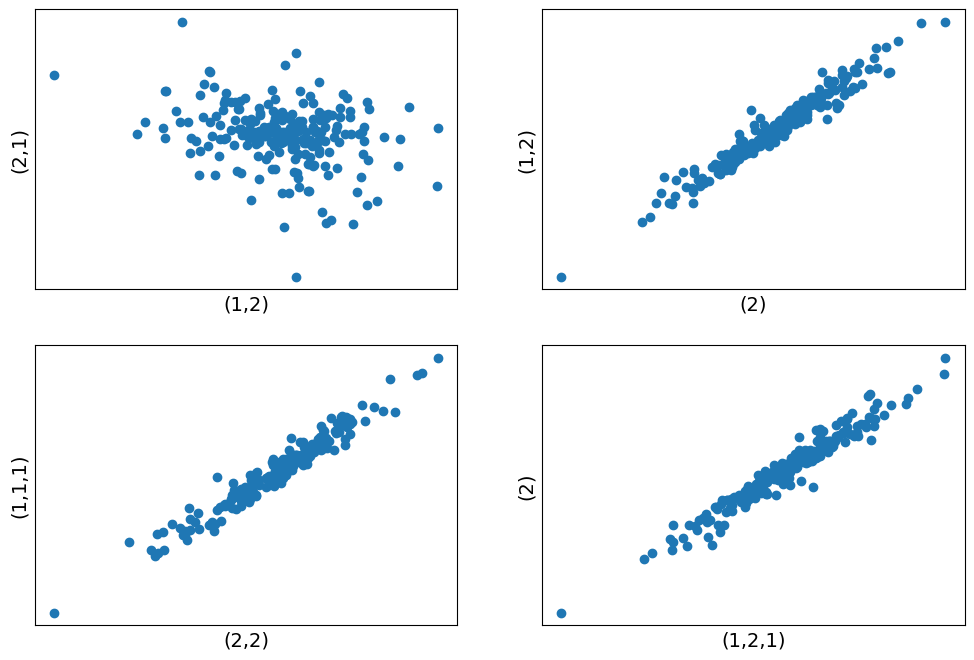

In [ ]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [ ]:
import process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

/tmp/ipykernel_11783/3136522855.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (219,) + inhomogeneous part.

## Invert log-signature

In [ ]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [ ]:
pip = 0.01
n_pips = 50 * 100 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

In [ ]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [ ]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

In [ ]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

In [ ]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

In [ ]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()